In [92]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from datetime import timedelta

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

from google.colab import drive
import matplotlib.pyplot as plt

In [93]:
SIZE_OF_MINUTE = 2
SIZE_OF_HOUR = 2*60
SIZE_OF_DAY = SIZE_OF_HOUR*24

In [94]:
# load data

drive.mount('/content/drive')

df_1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/case1-1_data.csv')
df_2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/case1-2_data.csv')


df_1.time = pd.to_datetime(df_1.time)
df_2.time = pd.to_datetime(df_2.time)


dataset = pd.concat([df_1, df_2], axis=0, ignore_index=True)

print(dataset)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                      time  requests
0      2021-03-30 05:05:30         1
1      2021-03-24 03:05:00       188
2      2021-03-27 06:15:00       519
3      2021-03-26 17:44:30      2939
4      2021-03-30 13:15:30      3407
...                    ...       ...
262463 2021-03-28 18:02:00         3
262464 2021-03-24 22:50:30        13
262465 2021-03-24 19:55:30     40880
262466 2021-03-27 16:28:30         2
262467 2021-03-25 22:11:30        34

[262468 rows x 2 columns]


In [95]:

# Let's count the number of requests at certain points in time. To do this, we will group the requests coming in at the same time.
dataset = dataset.groupby(by=['time'], as_index=False).sum()
dataset = dataset.sort_values(by="time")

In [96]:
# lets plot time series, and look to its statistical characteristics
 
def plotMovingAverage(series, n, number_of_points=240):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = series.rolling(window=n).mean()
    rolling_std = series.rolling(window=n).std()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(dataset.requests[-number_of_points:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

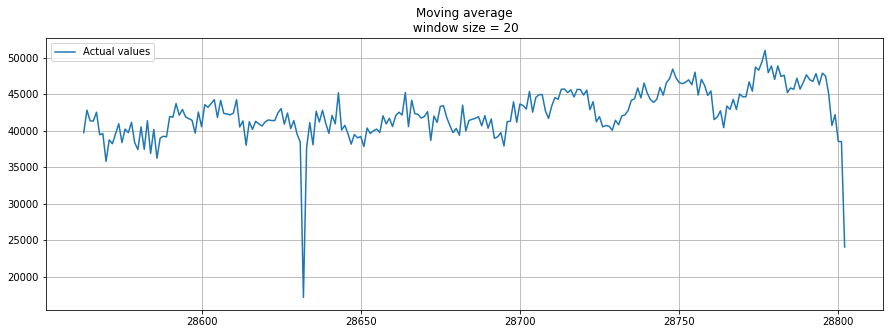

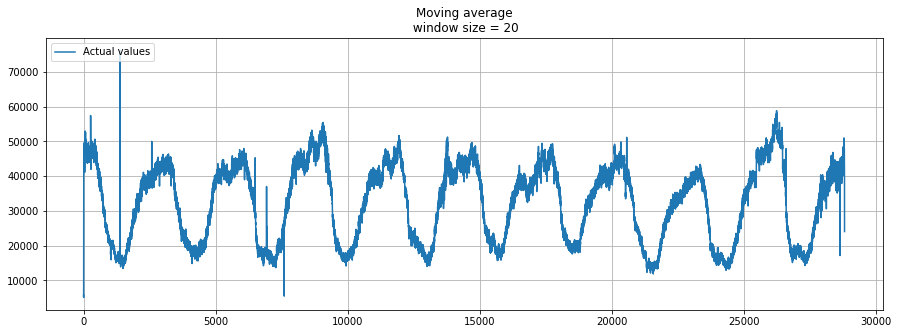

In [97]:


# smoothing by 10 minutes
plotMovingAverage(dataset, 20) 
plotMovingAverage(dataset, 20, SIZE_OF_DAY*10)

On the graph of the analyzed data, we observe abnormal emissions. A model predicting the behavior of a time series, ideally, should record such outliers.


In [98]:
# lets try to use triple exponental smothing

class HoltWinters:

    """
    Holt-Winters model with Brutlag method for detecting anomalies
    https://fedcsis.org/proceedings/2012/pliks/118.pdf

    # series - original time series
    # slen - the length of the season (must be at least half the length of the test data)
    # alpha, beta, gamma - coefficients of the Holt-Winters model
    # n_preds - prediction horizon
    # scaling_factor - sets the width of the Brutlag confidence interval (usually takes values ​​from 2 to 3)
    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  

    def initial_seasonal_components(self):
      
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])


In [99]:
#  automate the selection of model parameters

from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=2) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):
        model = HoltWinters(series=values[train], slen = SIZE_OF_DAY, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

In [100]:
data = dataset.requests[:-SIZE_OF_DAY*3] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.0007524681790046506 1.596833143274745e-05 0.0005904658301792431


In [121]:
# lets build model whit 5 days given and 5 days predicted

model_data_size = SIZE_OF_DAY*5
data = dataset[:model_data_size].requests

num_preds = dataset.requests.count()-model_data_size

# for using week period - it is nessesary to have data of 2 weeks data at least 
# usint 1 day period
model = HoltWinters(data, slen = SIZE_OF_DAY, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds=num_preds, scaling_factor = 2.56)
model.triple_exponential_smoothing()

In [118]:

def plotHoltWinters(smothed, start_from, title='', number_of_points=240):

    # Anomalies should be considered abrupt upward jumps in the load, 
    # which may indicate hacker attacks, or DDOS attacks.
    Anomalies = np.array([np.NaN]*len(dataset))
    Anomalies[dataset.requests>model.UpperBond] = dataset.requests[dataset.requests>model.UpperBond]

    actual_values = dataset.requests[start_from:start_from+number_of_points]
    actual_values = actual_values.to_list()




    plt.figure(figsize=(15,5))
    plt.title(title)

    plt.plot(actual_values, "b", label="actual values")

    plt.plot(smothed[start_from:start_from+number_of_points], "g", label="Holt Winters smothing")
    
    plt.plot(Anomalies[start_from:start_from+number_of_points], "o", markersize=10,  label = "Anomalies")

    plt.legend(loc="upper left")
    plt.grid(True)


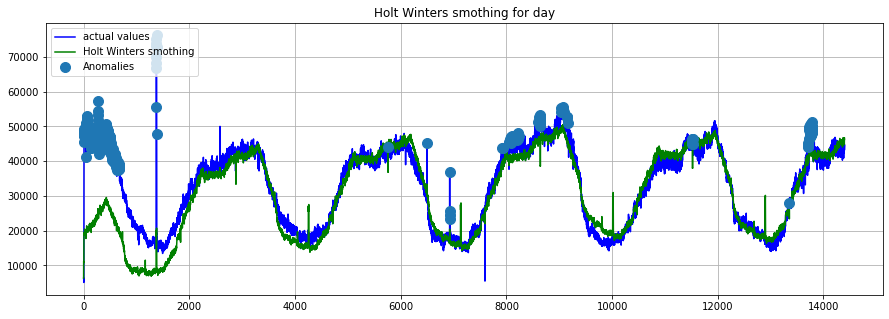

In [122]:
# visualise data analise 
plotHoltWinters(model.result, 0, title="Holt Winters smothing for day", number_of_points=SIZE_OF_DAY*5)


The data on the first day of server activity contained outliers both downward and upward, which somewhat worsened the prediction.

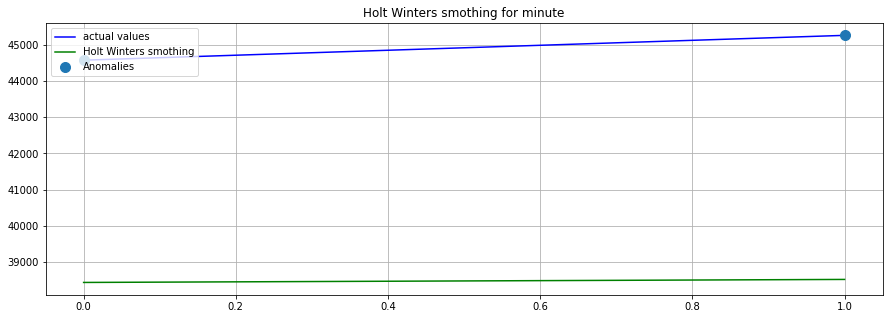

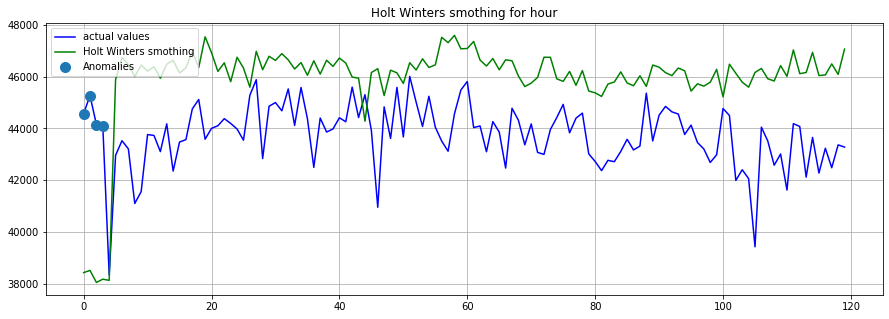

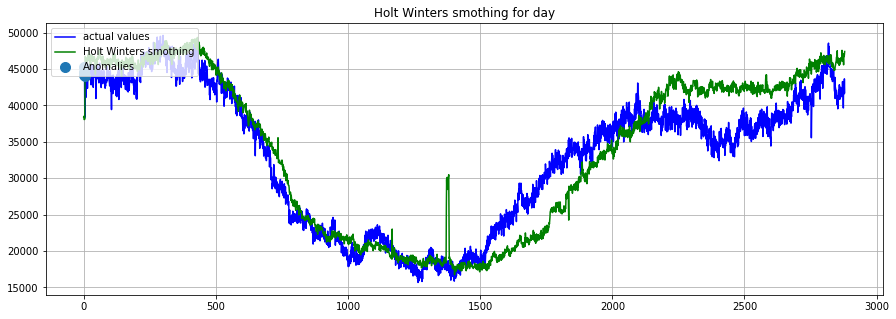

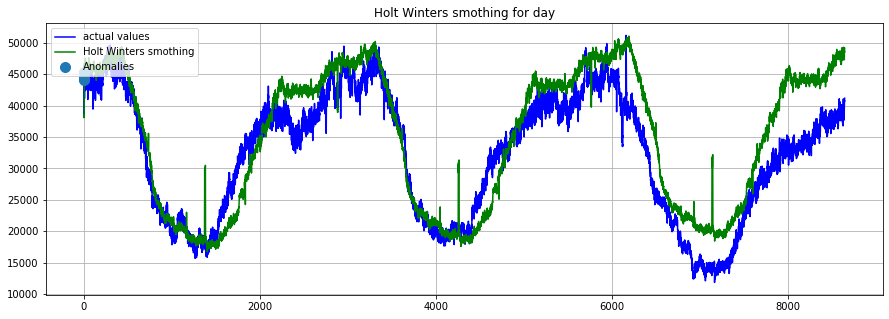

In [123]:
# visualise predictions
plotHoltWinters(model.result, model_data_size, title="Holt Winters smothing for minute", number_of_points=SIZE_OF_MINUTE)
plotHoltWinters(model.result, model_data_size, title="Holt Winters smothing for hour", number_of_points=SIZE_OF_HOUR)
plotHoltWinters(model.result, model_data_size, title="Holt Winters smothing for day", number_of_points=SIZE_OF_DAY)
plotHoltWinters(model.result, model_data_size, title="Holt Winters smothing for day", number_of_points=SIZE_OF_DAY*3)